In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data Import

In [44]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [45]:
img_directory = './dataset/img_align_celeba/'

In [46]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    img_directory, label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 202599 files belonging to 1 classes.


In [47]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [48]:
def preprocess(image):
    return tf.cast(image, tf.float32) /127.5 -1.0

In [49]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [50]:
for d in train_dataset.take(1):
    print(d.shape)

(128, 64, 64, 3)


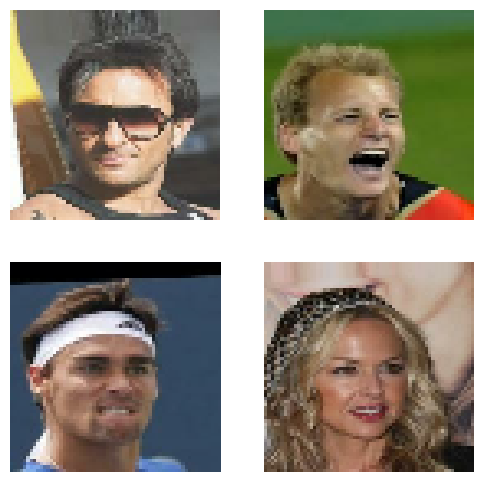

In [51]:
plt.figure(figsize=(6, 6))
k = 0
n = 4
for i in range(n):
    ax = plt.subplot(2, 2, k+1)
    plt.imshow((d[i]+1)/2) # this is done as each image value is between -1 to 1 so converting to 0 to 1
    plt.axis('off')
    k+=1

# Modeling

In [52]:
generator = tf.keras.Sequential([
    Input(shape=(LATENT_DIM)),
    Dense(4*4*LATENT_DIM),
    Reshape((4, 4, LATENT_DIM)),

    Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation=tf.keras.activations.tanh),
], name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1600)              161600    
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 8, 8, 512)         819712    
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 8, 8, 512)         2048      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 16, 16, 256)       20

In [53]:
discriminator = tf.keras.Sequential([
    Input(shape=(IM_SHAPE[0], IM_SHAPE[1], 3)),

    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(1, kernel_size=4, strides=2, padding='same'),
    
    Flatten(),
    Dense(1, activation='sigmoid')
], name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_13 (Ba  (None, 16, 16, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 256)         524544    
                                                     

In [54]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out = self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16, 16))
        for i in range(n):
            for j in range(n):
                ax = plt.subplot(n, n, k+1)
                plt.imshow((out[k]+1)/2)
                plt.axis('off')
                k+=1
        plt.savefig('generate/gen_images_epoch_{}'.format(epoch+1))
        plt.close('all')

In [55]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()

        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        #############Discriminator
        random_noise = tf.random.normal(shape=(batch_size, LATENT_DIM))
        fake_images = self.generator(random_noise)

        real_labels = tf.ones((batch_size, 1))+0.25*tf.random.uniform((batch_size, 1), minval=-1, maxval=1)
        fake_labels = tf.zeros((batch_size, 1))+0.25*tf.random.uniform((batch_size, 1))

        with tf.GradientTape() as recorder:
            real_predictions = self.discriminator(real_images)
            d_loss_real = self.loss_fn(real_labels, real_predictions)

            fake_predictions = self.discriminator(fake_images)
            d_loss_fake = self.loss_fn(fake_labels, fake_predictions)

            d_loss = d_loss_real + d_loss_fake
        
        partial_derivatives = recorder.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))


        ##############Generator

        random_noise = tf.random.normal(shape=(batch_size, LATENT_DIM))
        flipped_fake_labels= tf.ones((batch_size,1))

        with tf.GradientTape() as recorder:

            fake_predictions = self.discriminator(self.generator(random_noise))
            g_loss = self.loss_fn(flipped_fake_labels, fake_predictions)

        partial_derivatives = recorder.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss':self.d_loss_metric.result(),
                'g_loss':self.g_loss_metric.result()}


In [56]:
gan = GAN(discriminator, generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

In [58]:
EPOCHS=10
history=gan.fit(train_dataset.take(100),epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/10


      6/Unknown - 2s 324ms/step - d_loss: 1.2623 - g_loss: 0.8996WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0131s vs `on_train_batch_end` time: 0.2813s). Check your callbacks.
100/100 [==============================] - 34s 340ms/step - d_loss: 1.2289 - g_loss: 0.8935
Epoch 2/10
100/100 [==============================] - 34s 337ms/step - d_loss: 1.2330 - g_loss: 0.8460
Epoch 3/10
100/100 [==============================] - 34s 339ms/step - d_loss: 1.2230 - g_loss: 0.8887
Epoch 4/10
100/100 [==============================] - 35s 348ms/step - d_loss: 1.2456 - g_loss: 0.8660
Epoch 5/10
100/100 [==============================] - 35s 348ms/step - d_loss: 1.2504 - g_loss: 0.8107
Epoch 6/10
100/100 [==============================] - 35s 347ms/step - d_loss: 1.2351 - g_loss: 0.8117
Epoch 7/10
100/100 [==============================] - 35s 349ms/step - d_loss: 1.2323 - g_loss: 0.8149
Epoch 8/10
100/100 [==============================]

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()